# How to get most of NISQ computers with Qiskit

NISQ computers = Noisy Intermediate Scale Quantum computers

# What scale are we talking about?

* 2020 (now ) - 65 qubits (Hummingbird)
* 2021 - 121 qubits (Eagle)
* 2022 - 433 qubits (Osprey)
* 2023 - 1121 qubits (Condor)
* ? (around 2030?) - million qubits

# Quantum Volume
* Real capabilities of quantum computers are described by **Quantum Volume** - not number of qubits
* Currently biggest QV reached on IBM processors is **QV=64**
* This means we can run on average circuits with **57 CNOTs and 146 single-qubit gates** (this was average size of random quantum circuit generated for the benchmarking of QV=64)
* If we want our circuit to generate meaningful results, it needs to fit into this size **AFTER TRANSPILATION**

* Good news is that IBM plans to **double QV every year** (we achieved this already 4 years in a row)


# What is the 'noise' in NISQ ?

* Current quibits are not ideal, logical ones which we would like to have for our computation
* There are the following (most important) errors and problems resulting in errors:
    * Errors of implementing **single-qubit gates** - around 0.1% (best ~0.02%)
    * Errors of implementing **2-qubit gates (CNOTs)**- around 1% (best ~0.6%)
    * Qubit state **readout errors** - around 2% (best ~1%)
    * **Decoherence and relaxation** - after ~100us the comouter start to generate random results
    * **Topology limitations** - CNOT gates can not be applied between any 2 qubits directly. This results in the need of substituting certain gates with multiple other which mathematically are equivalent, but incrrease the overall number of gates in the circuit
    * Limited set of natively implemented gates - other gates need to be constructed with multiple native gates (also increasing the circuit size)
    * Errors vary largely between qubits in given processor

# So, what we need to do in order get most of NISQ computers?
* Use processor with smallest error rates for the problem (of course)
* Choose the qubits with smallest error rates among all in the processor
* Design your algorithm to use as small number of gates as possible
* Optimize the transpilation of your circuit
* Apply statistical readout errors mitigation

# How much all this can improve things?

* QV 64 was achieved on the same hardware on which QV 32 was previously achieved.
* This can improve everything - you can either obtain a result or no result (random one;)


# Today we'll use Qiskit for all these optimizations

# 1 - choosing the right qubits

In [1]:
%matplotlib inline
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, IBMQ
from qiskit.visualization import *
from qiskit.tools.jupyter import *
import pprint
from qiskit.tools.monitor import backend_overview, backend_monitor
from qiskit.ignis.mitigation.measurement import *
from qiskit.compiler import transpile, assemble
from qiskit.converters import circuit_to_dag
from qiskit.tools.visualization import dag_drawer
from qiskit.transpiler import PassManager
from qiskit.visualization import pass_manager_drawer
from qiskit.transpiler.passes import Unroller

In [2]:
provider = IBMQ.load_account()
backend = provider.get_backend('ibmq_16_melbourne')

C:\Anaconda3\lib\site-packages\qiskit\providers\ibmq\ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


In [3]:
backend_monitor(backend)

ibmq_16_melbourne
Configuration
-------------
    n_qubits: 15
    operational: True
    status_msg: active
    pending_jobs: 2298
    backend_version: 2.3.3
    basis_gates: ['id', 'u1', 'u2', 'u3', 'cx']
    local: False
    simulator: False
    open_pulse: False
    supported_instructions: ['u1', 'u2', 'u3', 'cx', 'id', 'x', 'measure', 'delay']
    url: None
    max_experiments: 75
    backend_name: ibmq_16_melbourne
    credits_required: True
    n_registers: 1
    memory: True
    conditional: False
    sample_name: albatross
    max_shots: 8192
    meas_map: [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]]
    dtm: 2.222222222222222e-19
    online_date: 2018-11-06 05:00:00+00:00
    multi_meas_enabled: False
    dt: 2.222222222222222e-19
    description: 15 qubit device
    quantum_volume: 8
    dynamic_reprate_enabled: False
    allow_object_storage: True
    coupling_map: [[0, 1], [0, 14], [1, 0], [1, 2], [1, 13], [2, 1], [2, 3], [2, 12], [3, 2], [3, 4], [3, 11], [4, 3], [4

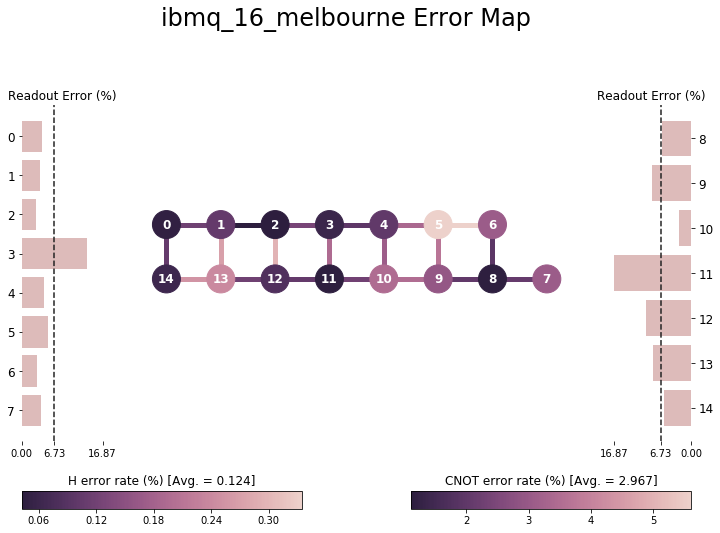

In [4]:
plot_error_map(backend)

# 2 - Mitigating readout errors

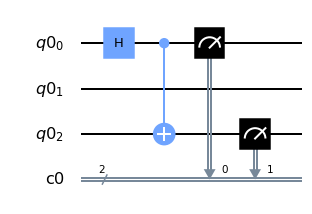

In [5]:
qr = QuantumRegister(3)
cr = ClassicalRegister(2)
circuit = QuantumCircuit(qr, cr)

circuit.h(qr[0])
circuit.cx(qr[0], qr[2])
circuit.measure(qr[0], cr[0])
circuit.measure(qr[2], cr[1])

circuit.draw(output='mpl')

In [6]:
#job = execute(circuit, backend=backend, shots=1024)

job=backend.retrieve_job('5d964483016e3a0018403075')
job.status()

<JobStatus.DONE: 'job has successfully run'>

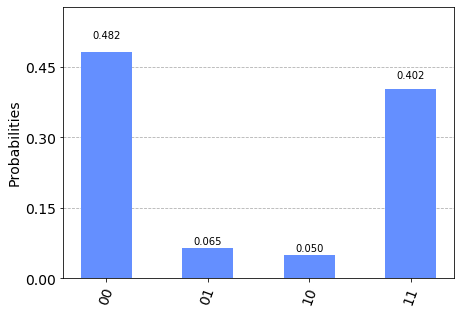

In [7]:
counts = job.result().get_counts()
plot_histogram(counts)

In [8]:
measurement_calibrations, state_labels = complete_meas_cal(qubit_list=[0,2])

In [9]:
len(measurement_calibrations)

4

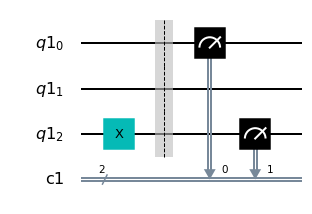

In [73]:
# We can visualize all the calibration circuits finding these are very simple ones ;)
measurement_calibrations[2].draw(output='mpl')

In [11]:
#job_calibration = execute(measurement_calibrations, backend=backend)

job_calibration = backend.retrieve_job('5d964e0689988b00183f9b34')

In [12]:
calibration_results = job_calibration.result()
measurement_fitter = CompleteMeasFitter(calibration_results, state_labels)

In [13]:
print(measurement_fitter.cal_matrix)

[[0.9609375  0.04003906 0.11425781 0.01953125]
 [0.03613281 0.95898438 0.00585938 0.109375  ]
 [0.00195312 0.         0.84375    0.05273438]
 [0.00097656 0.00097656 0.03613281 0.81835938]]


In [14]:
print(measurement_fitter.readout_fidelity())

0.8955078125


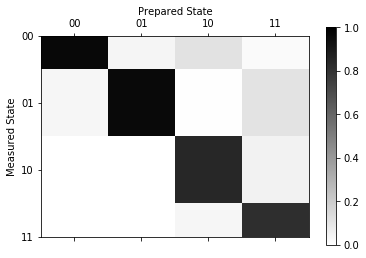

In [15]:
measurement_fitter.plot_calibration()

In [16]:
measurement_filter = measurement_fitter.filter
mitigated_counts = measurement_filter.apply(counts)

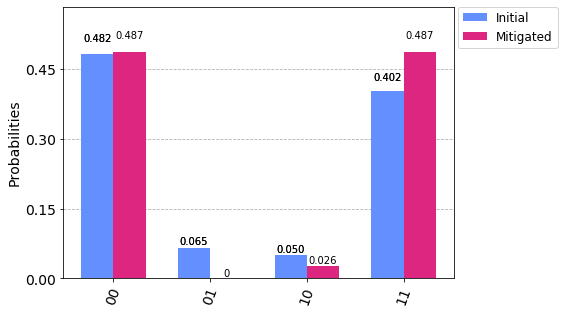

In [17]:
plot_histogram([counts, mitigated_counts], legend=["Initial", "Mitigated"])

### You can apply mitigation of readout errors on any set of qubits used (not necessarily on all)

# 3 - optimized transpilation

In [18]:
backend2 = provider.get_backend('ibmq_ourense')

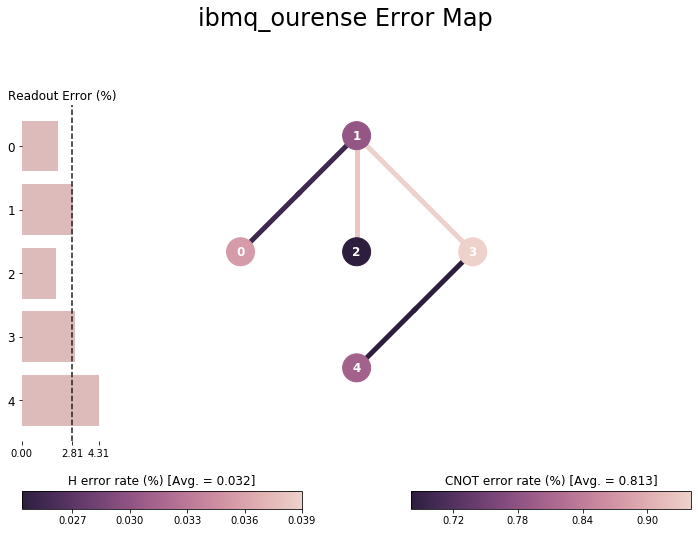

In [19]:
plot_error_map(backend2)

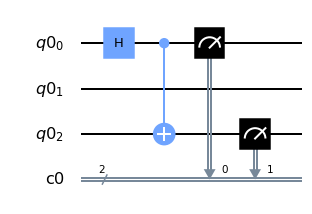

In [20]:
circuit.draw(output='mpl')

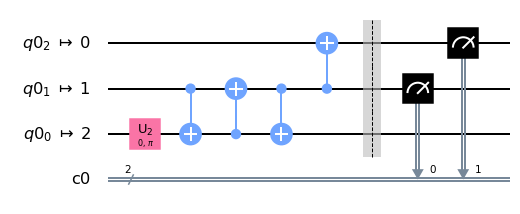

In [63]:
transpiled_circuit = transpile(circuit, backend2)
transpiled_circuit.draw(output='mpl', idle_wires=False)

In [60]:
pprint.pprint(backend2.configuration().basis_gates)

['id', 'u1', 'u2', 'u3', 'cx']


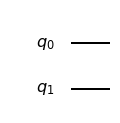

In [61]:
swap_example_circuit = QuantumCircuit(2)
swap_example_circuit.decompose().draw(output='mpl')

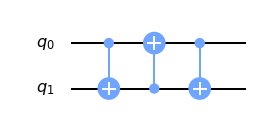

In [62]:
swap_example_circuit.swap(0, 1)
swap_example_circuit.decompose().draw(output='mpl')

# Transpiler optimization levels (USE THEM!!!)
* `optimization_level=0`: just maps the circuit to the backend, with no explicit optimization (except whatever optimizations the mapper does)

* `optimization_level=1`: maps the circuit, but also does light-weight optimizations by collapsing adjacent gates.

* `optimization_level=2`: medium-weight optimization, including a noise-adaptive layout and a gate-cancellation procedure based on gate commutation relationships.

* `optimization_level=3`: heavy-weight optimization, which in addition to previous steps, does resynthesis of two-qubit blocks of gates in the circuit.

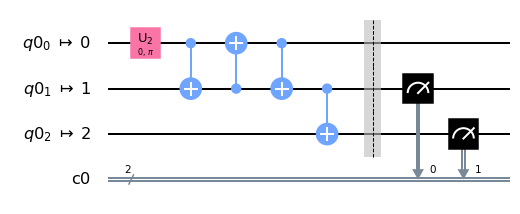

In [77]:
# See that result of transpilation is not-deterministic (run this few times on level 0)
# Circuit depth is not-deterministic too!

transpiled_circuit = transpile(circuit, backend2, optimization_level=0)
transpiled_circuit.draw(output='mpl', idle_wires=False)

In [78]:
transpiled_circuit.depth()

6

* In Qiskit, we represent circuits internally using a Directed Acyclic Graph (DAG).
* Three kinds of graph nodes exist: qubit/clbit input nodes (green), operation nodes (blue), and output nodes (red).
* Each edge indicates data flow (or dependency) between two nodes.

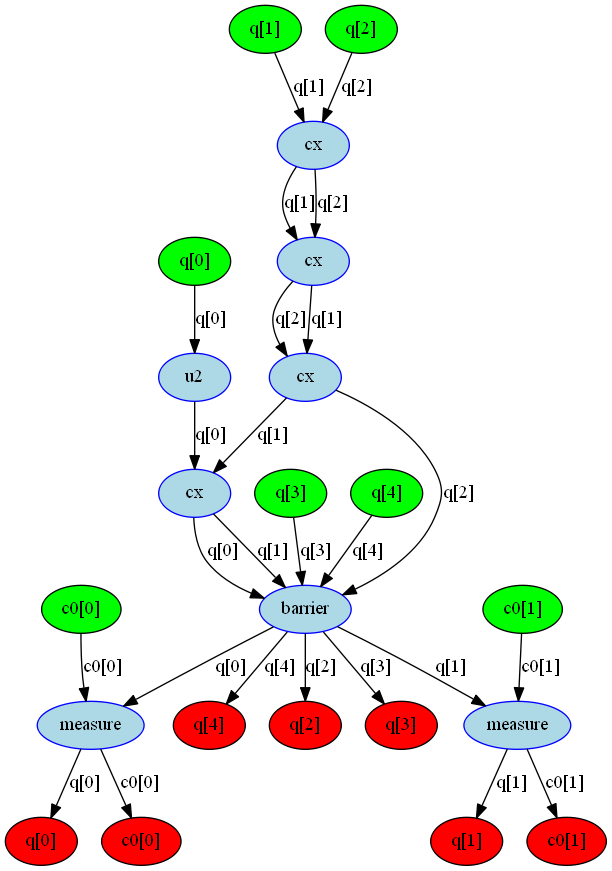

In [68]:
from IPython.display import display
from PIL import Image

dag = circuit_to_dag(transpiled_circuit)
dag_drawer(dag, filename='C:\\temp\\dag.png')
display(Image.open('C:\\temp\\dag.png'))

## Let's see how this works for bigger circuits. Let's use Melbourne backend again...


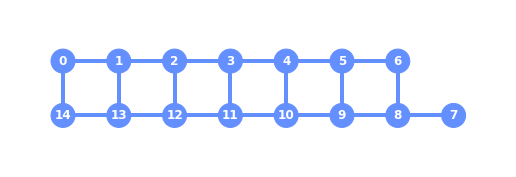

In [69]:
plot_gate_map(backend)

In [70]:
qr2 = QuantumRegister(14)
cr2 = ClassicalRegister(14)
circuit2 = QuantumCircuit(qr2, cr2)

circuit2.h(qr2[0])
circuit2.cx(qr2[0], qr2[6])
circuit2.cx(qr2[6], qr2[13])
circuit2.cx(qr2[13], qr2[7])
circuit2.cx(qr2[7], qr2[0])
circuit2.measure(qr2, cr2)

#circuit2.draw(output='mpl')

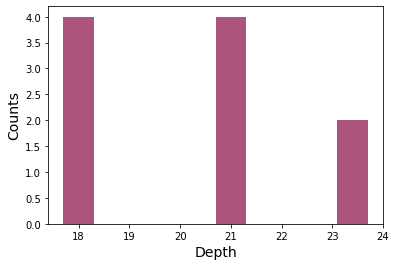

In [71]:
import matplotlib.pyplot as plt

depths = []
for _ in range(10):
    depths.append(transpile(circuit2, backend).depth())

plt.hist(depths, align='left', color='#AC557C')
plt.xlabel('Depth', fontsize=14)
plt.ylabel('Counts', fontsize=14);

In [72]:
for level in range(4):
    transpiled_circuit2 = transpile(circuit2, backend, optimization_level=level)
    print('---------- Level = ' + str(level) + ' ----------')
    print('gates = ', transpiled_circuit2.count_ops())
    print('depth = ', transpiled_circuit2.depth())

---------- Level = 0 ----------
gates =  OrderedDict([('cx', 46), ('measure', 14), ('u2', 1), ('barrier', 1)])
depth =  29
---------- Level = 1 ----------
gates =  OrderedDict([('cx', 37), ('measure', 14), ('u2', 1), ('barrier', 1)])
depth =  21
---------- Level = 2 ----------
gates =  OrderedDict([('measure', 14), ('cx', 4), ('u2', 1)])
depth =  6
---------- Level = 3 ----------
gates =  OrderedDict([('measure', 14), ('cx', 4), ('u2', 1)])
depth =  6


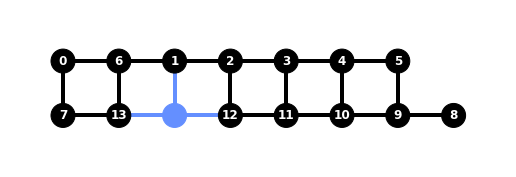

In [34]:
plot_circuit_layout(transpiled_circuit2, backend)

# How transpiler works?

* Transpiler uses so called PassManager (depending on optimization level)
* Pass Manager does a set of passes transforming the circuit until the final shape.
* Passes can be transformation passes or analysis passes.
* Analytical passes write conclusions in a commonly accessible properties
* Transformation passes trandform the circuit by using the properties from analysis (in read-only mode)

* Passes are divided into the following categories:
    * **yout selection** mapping virtual to physical qubits
    * **Routing** - using swap gates mapping algorithm to procesor topology
    * **Basis change** - map gates used in the algorithm to the natively available ones
    * **Optimizations** - replacing sets of gates with just one, cancelling not needed gates, etc.
    * **Analysis** - counting operations, calculating width, depth, etc.
    * Other...

* There are pre-defined PassManager implementations depending on optimization levels
* One can use a custom PassManager which will be tuned for certain applications.

* More details: https://qiskit.org/documentation/apidoc/transpiler_passes.html

In [35]:
#Getting info about all existing transpiler passes:

from qiskit.transpiler import passes
i = 1
for passitem in dir(passes):
    if passitem[0].isupper(): 
        print(str(i) + '\t' + passitem)
        i=i+1

1	ApplyLayout
2	BarrierBeforeFinalMeasurements
3	BasicSwap
4	BasisTranslator
5	CSPLayout
6	CXCancellation
7	CXDirection
8	CheckCXDirection
9	CheckMap
10	Collect2qBlocks
11	CommutationAnalysis
12	CommutativeCancellation
13	ConsolidateBlocks
14	CountOps
15	CountOpsLongestPath
16	CrosstalkAdaptiveSchedule
17	DAGFixedPoint
18	DAGLongestPath
19	Decompose
20	DenseLayout
21	Depth
22	EnlargeWithAncilla
23	FixedPoint
24	FullAncillaAllocation
25	HoareOptimizer
26	Layout2qDistance
27	LayoutTransformation
28	LookaheadSwap
29	MergeAdjacentBarriers
30	NoiseAdaptiveLayout
31	NumTensorFactors
32	Optimize1qGates
33	OptimizeSwapBeforeMeasure
34	RemoveDiagonalGatesBeforeMeasure
35	RemoveFinalMeasurements
36	RemoveResetInZeroState
37	ResourceEstimation
38	SabreLayout
39	SabreSwap
40	SetLayout
41	Size
42	StochasticSwap
43	TrivialLayout
44	UnitarySynthesis
45	Unroll3qOrMore
46	UnrollCustomDefinitions
47	Unroller
48	Width


### Let's use our initial simple Bell state circuit to visualize the concept...

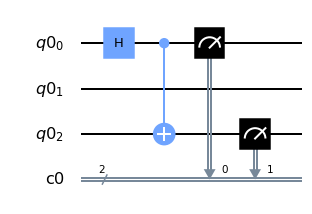

In [36]:
circuit.draw(output='mpl')

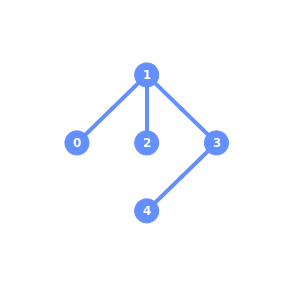

In [37]:
plot_gate_map(backend2)

**Initial layout** - mapping 'virtual' qubits onto the physical qubits in quantum processor
* Trivial layout (levels 0 and 1): maps virtual qubits to the same numbered physical qubits, i.e. [0,1,2,3,4] -> [0,1,2,3,4]
* Dense layout (levels 2 and 3): Find the sub-graph of the device with same number of qubits as the circuit with the greatest connectivity

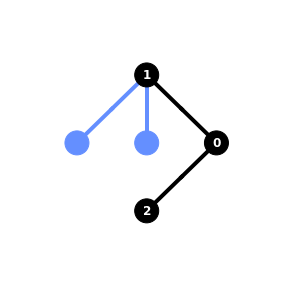

In [38]:
transpiled_circuit_initial_map = transpile(circuit, backend2, initial_layout=[3, 1, 4])
# Virtual -> physical
#    0    ->    3
#    1    ->    1
#    2    ->    4

plot_circuit_layout(transpiled_circuit_initial_map, backend2)

**StochasticSwap** - finds set of swaps which move qubits' states in such way, that it is possible to implement all CNOT gates in the circuit. This is a stochastic heuristic algorithm.

**Unroller** - represents circuit gates with natively implemented ones

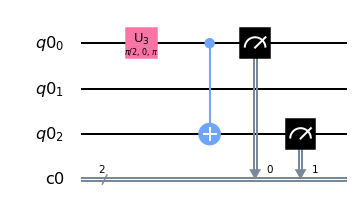

In [43]:
pass_ = Unroller(['u3', 'cx'])
pm = PassManager(pass_)

# Unroller transforms the gates in the initial circuit to native set of gates implemented on given device

new_circuit = pm.run(circuit)
new_circuit.draw(output='mpl')

#pass_manager_drawer(pm, filename='C:\\temp\\dag.png')

You can create circuit for your custom native set of gates if needed.

In [44]:
import logging

logging.basicConfig(level='INFO')
transpiled_circuit=transpile(circuit, backend2, optimization_level=0)

#transpiled_circuit.draw(output='mpl')

INFO:qiskit.transpiler.runningpassmanager:Pass: SetLayout - 0.00000 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: TrivialLayout - 0.00000 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: FullAncillaAllocation - 0.00000 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: EnlargeWithAncilla - 0.00000 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: ApplyLayout - 1.00613 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: Unroll3qOrMore - 0.00000 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: CheckMap - 1.00303 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: BarrierBeforeFinalMeasurements - 1.00112 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: StochasticSwap - 7.99656 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: UnrollCustomDefinitions - 1.00064 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('cx', 2), ('swap', 2), ('barrier', 5), ('measure', 1), ('h', 1)} to target basis {'u2', 'measure', 'id',

# What future will (should :) bring?

* Smaller gates and measurement errors
* Logical qubits thanks to QEC (Quantum Error Correction) algorithms
* Transpiler enhancements

# What can you start working on currently?

The future quantum processors will have heavy-hexagonal lattice structure, so you can start tuning your algorithms to this topology.


In [49]:
logging.disable(sys.maxsize)